In [1]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
#Load the Data    

df = pd.read_csv('C:\\Users\\heath\\Downloads\\mlb-player-stats-Batters (1).csv', encoding='utf-8')

In [3]:
# This will filter the data to players that had a minimum of 100 at bats to imrpove accuracy (players with just a few at bats are virtually impossible to predict)

min_ab = 100
df = df[df['AB'] >= min_ab].copy()
df = df.reset_index(drop=True)

In [4]:
# empty war column
df['WAR'] = 0.0

In [5]:
print("Calculating war")


Calculating war


In [6]:
# here calcualating intermediate values for different types of hits (singles, doubles, triples, homeruns, walks, hit-by-pitches, at bats)

df['Singles'] = df['H'] - df['2B'] - df['3B'] - df['HR']
df['BattingRuns'] = (df['Singles'] * 0.47 + 
                    df['2B'] * 0.78 + 
                    df['3B'] * 1.09 + 
                    df['HR'] * 1.40 + 
                    df['BB'] * 0.33 + 
                    df['HBP'] * 0.33 - 
                    (df['AB'] - df['H']) * 0.25)
df['BattingRuns'] = df['BattingRuns'] - (df['AB'] / 600) * 20    # league adjustment

In [7]:

df['BaseRunningRuns'] = (df['SB'] * 0.2) - (df['CS'] * 0.4)
df['FieldingRuns'] = 0  

In [8]:
# positional adjustment since overall value can be altered by which position someone plays

pos_adjustments = {
    'C': 12.5, 'SS': 7.5, '2B': 2.5, 'CF': 2.5, '3B': 2.5, 
    'RF': -7.5, 'LF': -7.5, '1B': -12.5, 'DH': -17.5
}

In [9]:
# apply positional adjustments

df['PosAdjustment'] = df.apply(
    lambda row: pos_adjustments.get(row['Pos'], 0) * (row['G'] / 162), 
    axis=1
)

df['LeagueAdjustment'] = 0
df['ReplacementRuns'] = 20 * (df['G'] / 162)
df['RunsPerWin'] = 10.0

In [10]:
# had to manually calculate wins above replacement since it wasn't included in the data (weird, in my opinion. It's a vital statistic when evaluating a player's value)

df['WAR'] = (df['BattingRuns'] + df['BaseRunningRuns'] + df['FieldingRuns'] + 
            df['PosAdjustment'] + df['LeagueAdjustment'] + df['ReplacementRuns']) / df['RunsPerWin']

In [12]:
# prints the lowest WAR value in the dataset, along with the highest, and averages all values out

print(f"War calculation finished. Here are the amount of players with war: {len(df[df['WAR'] != 0])}")
print(f"WAR stats - Min: {df['WAR'].min():.2f}, Max: {df['WAR'].max():.2f}, Avg: {df['WAR'].mean():.2f}")

War calculation finished. Here are the amount of players with war: 455
WAR stats - Min: -2.24, Max: 10.53, Avg: 0.62


In [11]:
# corrleation matrix to meausre replationship between these particular stats and WAR

stats_columns = ['Age', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 
                 'BB', 'SO', 'SH', 'SF', 'HBP', 'AVG', 'OBP', 'SLG', 'OPS', 'WAR']
correlation_df = df[stats_columns].copy()

correlation_matrix = correlation_df.corr()
correlations = correlation_matrix['WAR'].drop('WAR').sort_values(ascending=False)
    

In [12]:
#identify the two stats that have the highest correlation with WAR and print them. They are OPS (on base percentage + slugging,) and Slugging, which measures how many bases a player averages per at bat

top_two_stats = correlations.index[:2].tolist()
print(f"Top 2 stats most correlated with WAR: {top_two_stats}")
print(f"Correlations: {top_two_stats[0]}: {correlations[top_two_stats[0]]:.4f}, {top_two_stats[1]}: {correlations[top_two_stats[1]]:.4f}")

Top 2 stats most correlated with WAR: ['OPS', 'SLG']
Correlations: OPS: 0.8262, SLG: 0.7782


In [13]:

# Here r^2 values are calcualted, which are measuring how well each of these stats predict WAR

r2_values = {}
for column in correlation_df.columns:
    if column != 'WAR':
        X = correlation_df[column].values.reshape(-1, 1)
        y = correlation_df['WAR'].values
        model = LinearRegression()
        model.fit(X, y)
        r2 = r2_score(y, model.predict(X))
        r2_values[column] = r2

In [21]:
r2_series = pd.Series(r2_values).sort_values(ascending=False)
print(f"Top stats by R²: {r2_series.index[0]}: {r2_series[0]:.4f}, {r2_series.index[1]}: {r2_series[1]:.4f}")

Top stats by R²: OPS: 0.6826, SLG: 0.6056


C:\Users\heath\AppData\Local\Temp\ipykernel_20280\1155681146.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Top stats by R²: {r2_series.index[0]}: {r2_series[0]:.4f}, {r2_series.index[1]}: {r2_series[1]:.4f}")


Saved correlation heatmap


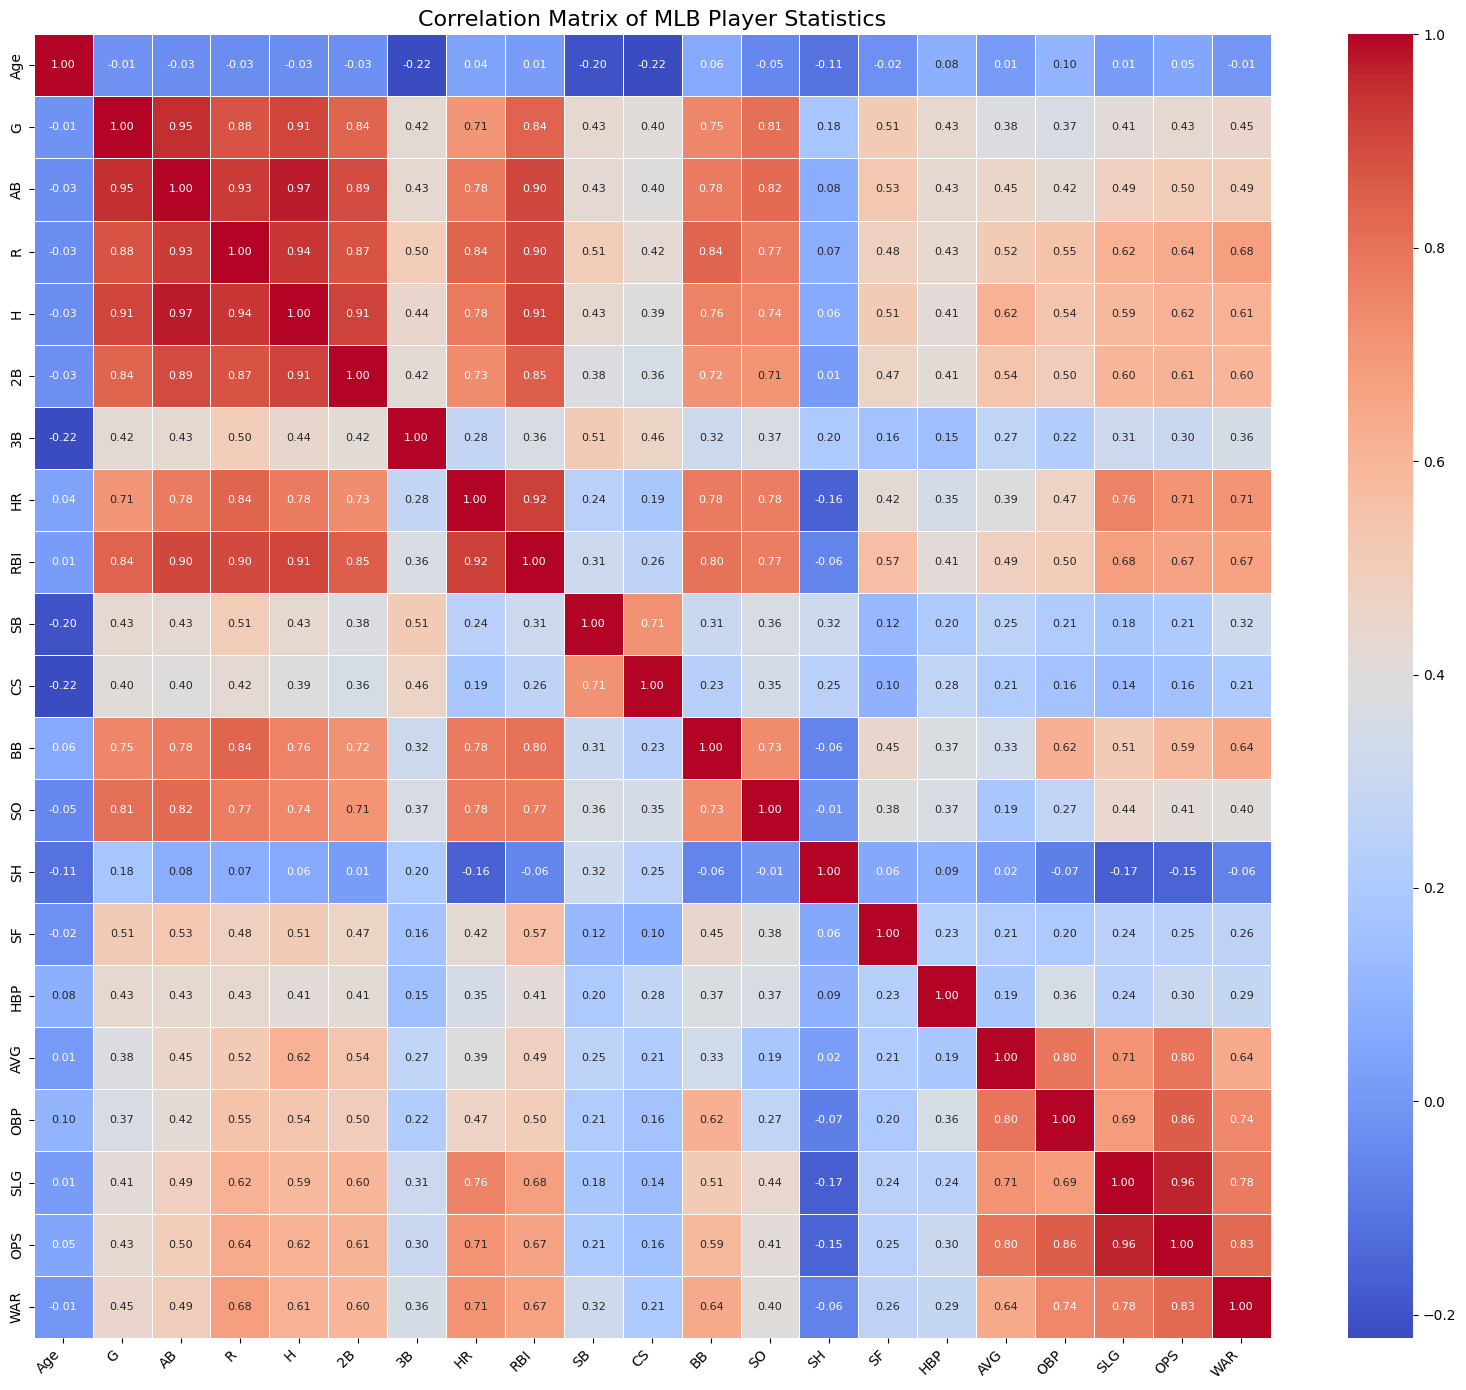

In [22]:
# heatmap of correlation of MLB stast


plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            linewidths=0.5, annot_kws={"size": 8})
plt.title("Correlation Matrix of MLB Player Statistics", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('full_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved correlation heatmap")

C:\Users\heath\AppData\Local\Temp\ipykernel_20280\1965221467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="viridis")


Saved WAR correlation bar chart


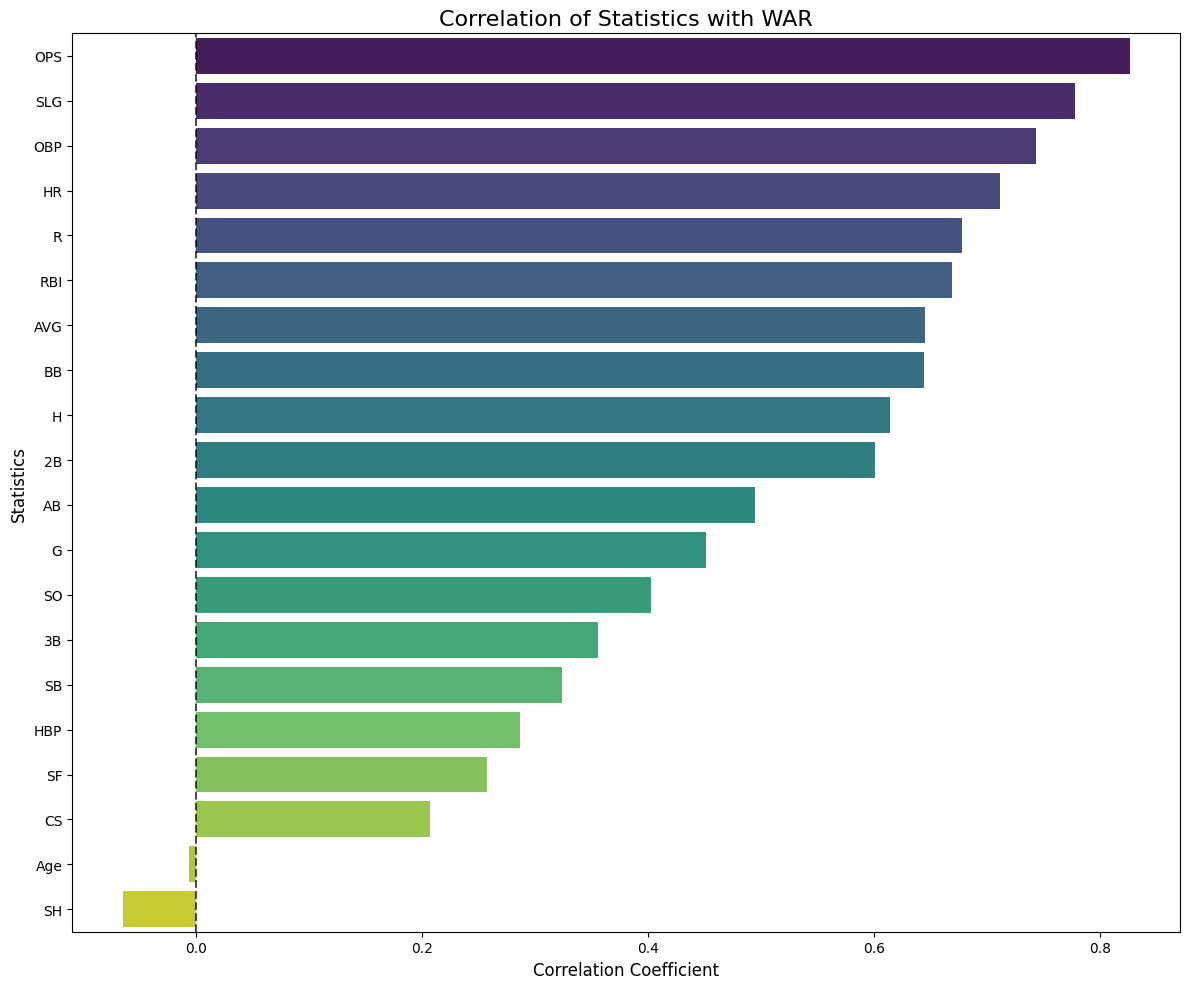

In [23]:
# bar graph that depicts corrleation between every stat and WAR

plt.figure(figsize=(12, 10))
sns.barplot(x=correlations.values, y=correlations.index, palette="viridis")
plt.title("Correlation of Statistics with WAR", fontsize=16)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Statistics", fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('war_correlation_barplot.png', dpi=300, bbox_inches='tight')
print("Saved WAR correlation bar chart")

C:\Users\heath\AppData\Local\Temp\ipykernel_20280\1513958306.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=r2_series.values, y=r2_series.index, palette="magma")


Saved R² bar chart


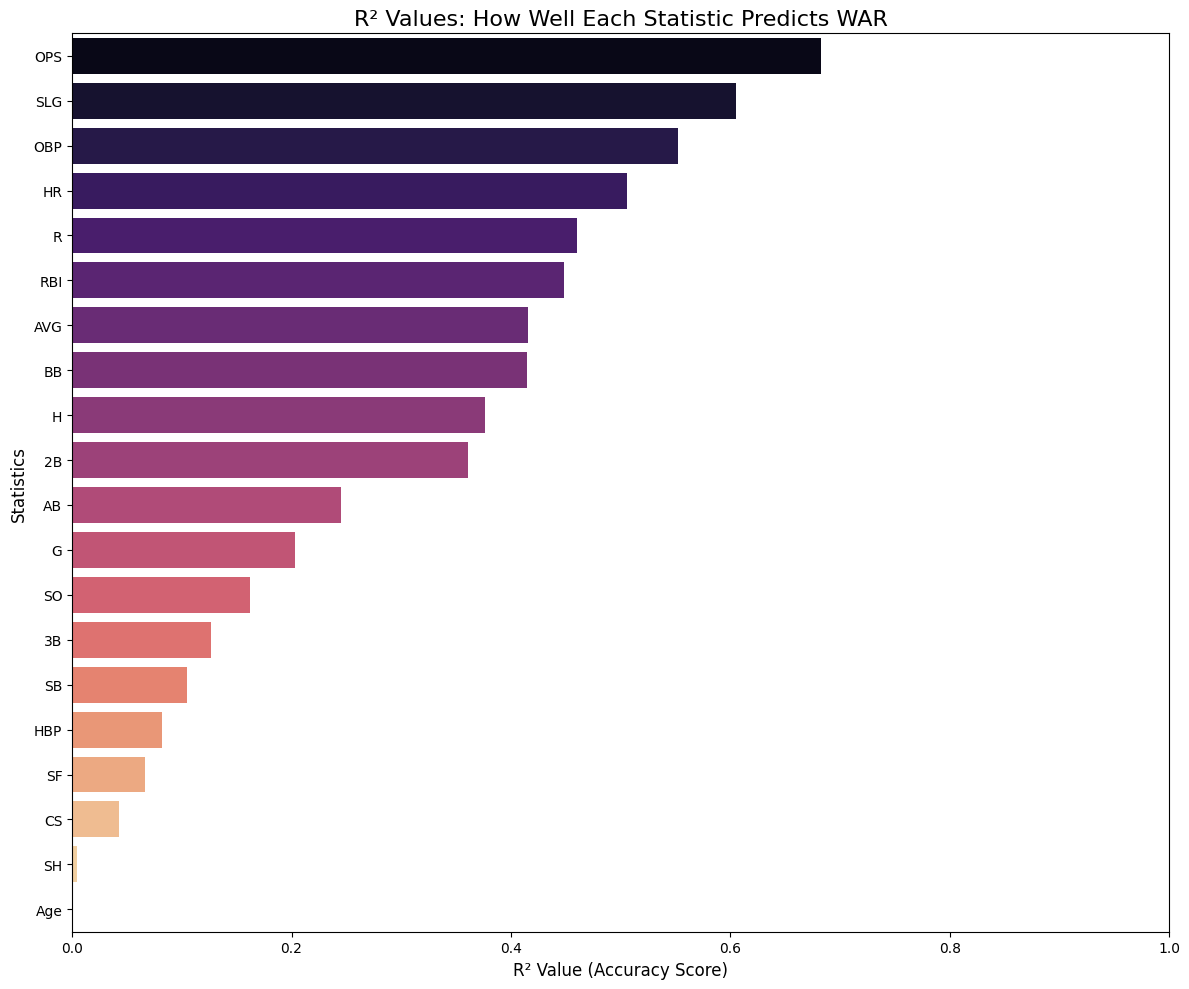

In [24]:
# visualization of the r^2 calculations

plt.figure(figsize=(12, 10))
sns.barplot(x=r2_series.values, y=r2_series.index, palette="magma")
plt.title("R² Values: How Well Each Statistic Predicts WAR", fontsize=16)
plt.xlabel("R² Value (Accuracy Score)", fontsize=12)
plt.ylabel("Statistics", fontsize=12)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('war_r2_barplot.png', dpi=300, bbox_inches='tight')
print("Saved R² bar chart")

In [25]:
#linear progression model
X = correlation_df[top_two_stats]
y = correlation_df['WAR']
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [26]:
# model coefficients 

print("Model coefficients:")
for stat, coef in zip(top_two_stats, model.coef_):
    print(f"{stat}: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

Model coefficients:
OPS: 14.3473
SLG: -4.9362
Intercept: -7.4436


In [27]:
# predict WAR using our current statistics


correlation_df['Predicted_WAR'] = model.predict(X)

Text(0, 0.5, 'Predicted WAR')

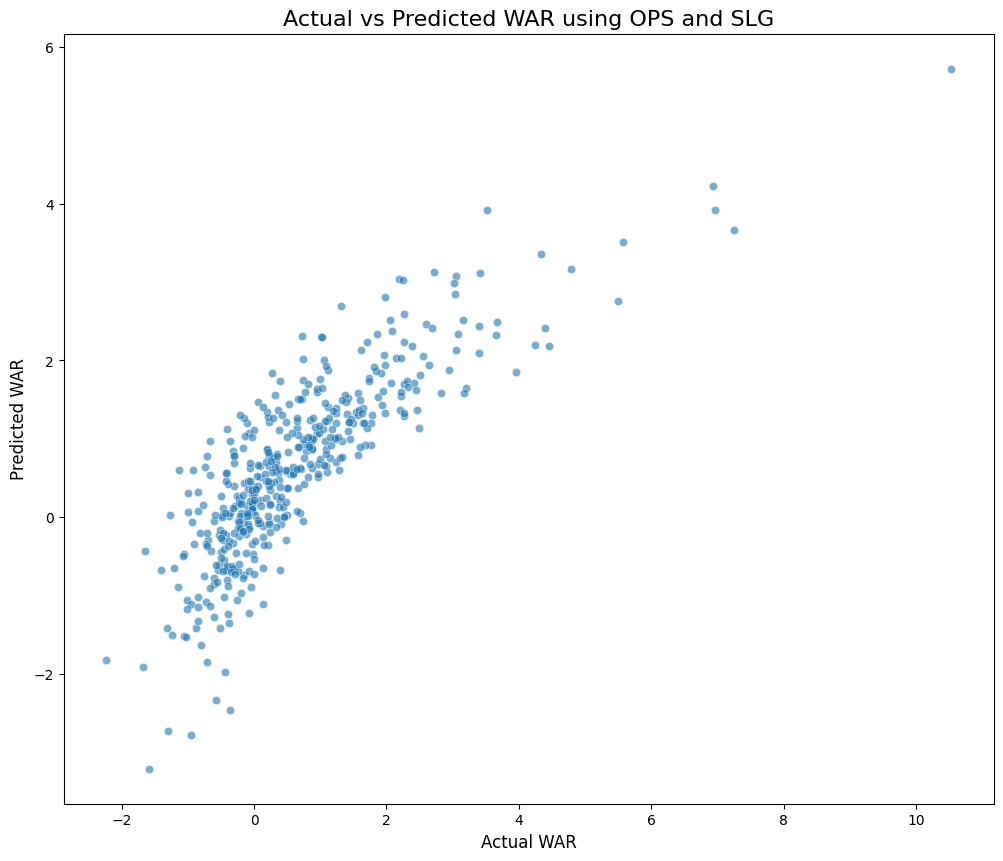

In [28]:
# scatter plot that charts actual vs predicted WAR using our two best stats

plt.figure(figsize=(12, 10))
sns.scatterplot(x='WAR', y='Predicted_WAR', data=correlation_df, alpha=0.6)
plt.title(f"Actual vs Predicted WAR using {top_two_stats[0]} and {top_two_stats[1]}", fontsize=16)
plt.xlabel("Actual WAR", fontsize=12)
plt.ylabel("Predicted WAR", fontsize=12)

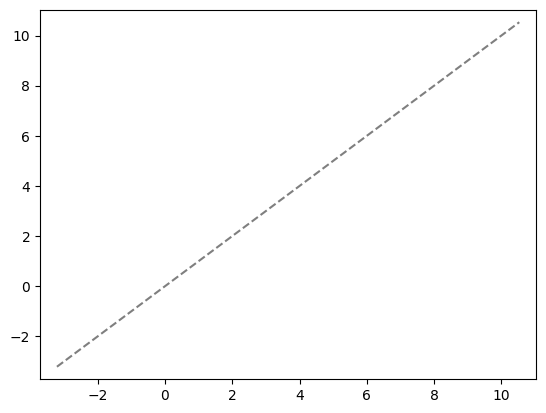

In [29]:
min_val = min(correlation_df['WAR'].min(), correlation_df['Predicted_WAR'].min())
max_val = max(correlation_df['WAR'].max(), correlation_df['Predicted_WAR'].max())
plt.xlim(min_val - 0.5, max_val + 0.5)
plt.ylim(min_val - 0.5, max_val + 0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

In [30]:

df_2025 = df.copy()

In [31]:
# growth factors based on age

df_2025['Age_2025'] = df_2025['Age'] + 1
df_2025['GrowthFactor'] = 1.0  

In [32]:
df_2025.loc[df_2025['Age_2025'] < 27, 'GrowthFactor'] = 1.05  # young players improve
df_2025.loc[(df_2025['Age_2025'] >= 27) & (df_2025['Age_2025'] <= 32), 'GrowthFactor'] = 1.0  # prime years (generally 27-32)
df_2025.loc[df_2025['Age_2025'] > 32, 'GrowthFactor'] = df_2025.loc[df_2025['Age_2025'] > 32].apply(
    lambda row: max(0.90, 1 - (row['Age_2025'] - 32) * 0.02), axis=1)  # generally start to decline after age 32

In [33]:
for stat in top_two_stats:
    # creates same column name with no suffix for prediction
    df_2025[stat + '_projected'] = df_2025[stat]  # copies original value
    
    if stat in ['OBP', 'SLG', 'OPS', 'AVG']:  # rates stats
        ceiling = 0.450 if stat == 'OBP' else 0.700 if stat == 'SLG' else 1.100 if stat == 'OPS' else 0.350
        df_2025[stat + '_projected'] = df_2025.apply(
            lambda row: min(row[stat] * row['GrowthFactor'], ceiling), axis=1)
    else:  # counts stats
        df_2025[stat + '_projected'] = df_2025[stat] * df_2025['GrowthFactor']

In [34]:
X_2025 = df_2025[[stat + '_projected' for stat in top_two_stats]]
X_2025.columns = top_two_stats  # renames columns to match what model was trained on

In [35]:
# predict WAR values for the 2025 season

df_2025['Projected_2025_WAR'] = model.predict(X_2025)

In [36]:
print("\nDetermining the top players by WAR for 2025...")
top_players_2025 = df_2025.sort_values('Projected_2025_WAR', ascending=False).head(15)


Determining the top players by WAR for 2025...


In [37]:
print("\nProjections for the top 15 players by WAR for the 2025 season:")
for idx, row in top_players_2025.iterrows():
    print(f"{row['Player']} ({row['Team']}, {row['Pos']}): {row['Projected_2025_WAR']:.2f} WAR - " + 
          f"{top_two_stats[0]}: {row[top_two_stats[0] + '_projected']:.2f}, " + 
          f"{top_two_stats[1]}: {row[top_two_stats[1] + '_projected']:.2f}")


Projections for the top 15 players by WAR for the 2025 season:
Aaron Judge (NYY, OF): 4.95 WAR - OPS: 1.10, SLG: 0.69
Shohei Ohtani (LAD, DH): 4.23 WAR - OPS: 1.04, SLG: 0.65
Bobby Witt (KC, SS): 4.23 WAR - OPS: 1.03, SLG: 0.62
Juan Soto (NYY, OF): 3.92 WAR - OPS: 0.99, SLG: 0.57
Kyle Tucker (HOU, OF): 3.92 WAR - OPS: 0.99, SLG: 0.58
Vladimir Guerrero (TOR, 1B): 3.90 WAR - OPS: 0.99, SLG: 0.57
Yordan Alvarez (HOU, OF): 3.52 WAR - OPS: 0.96, SLG: 0.57
Gunnar Henderson (BAL, SS): 3.27 WAR - OPS: 0.94, SLG: 0.56
Ketel Marte (ARI, 2B): 3.16 WAR - OPS: 0.93, SLG: 0.56
Brent Rooker (OAK, DH): 3.08 WAR - OPS: 0.93, SLG: 0.56
Kerry Carpenter (DET, OF): 3.03 WAR - OPS: 0.93, SLG: 0.59
Carlos Correa (MIN, SS): 2.99 WAR - OPS: 0.91, SLG: 0.52
Joc Pederson (ARI, DH): 2.83 WAR - OPS: 0.89, SLG: 0.50
Matt Wallner (MIN, OF): 2.82 WAR - OPS: 0.90, SLG: 0.52
Xavier Edwards (MIA, SS): 2.72 WAR - OPS: 0.86, SLG: 0.44


C:\Users\heath\AppData\Local\Temp\ipykernel_20280\3010077651.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Projected_2025_WAR', y='Player', data=top_10_players, palette='viridis')


Saved top 2025 players chart

Analysis complete! All visualizations have been saved.


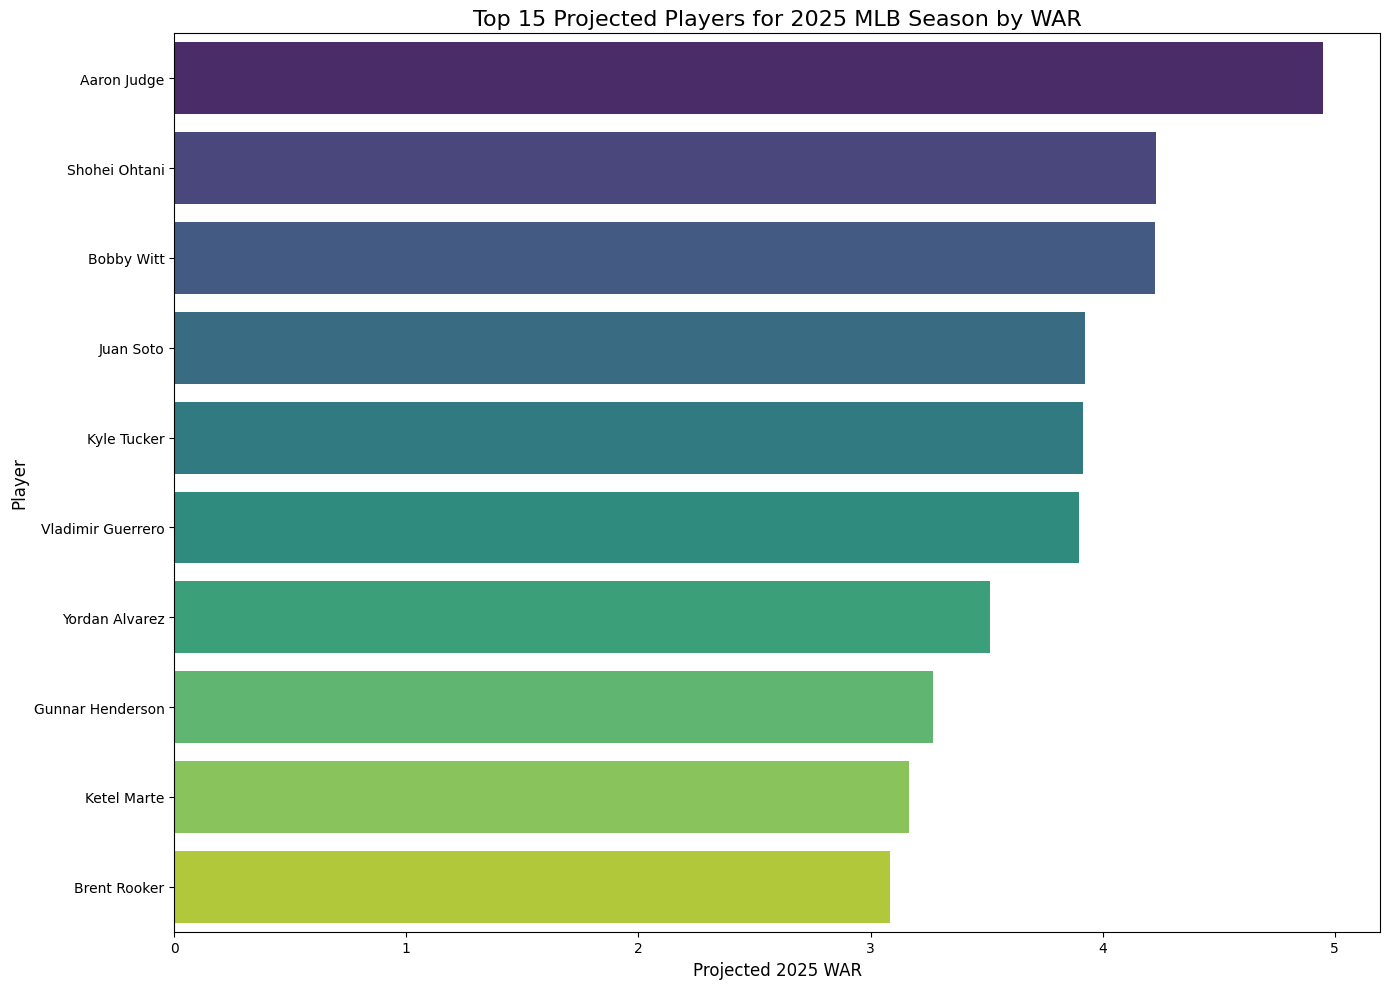

In [38]:
# bar graph of the top 15 players

plt.figure(figsize=(14, 10))
top_10_players = top_players_2025.head(10)
sns.barplot(x='Projected_2025_WAR', y='Player', data=top_10_players, palette='viridis')
plt.title("Top 15 Projected Players for 2025 MLB Season by WAR", fontsize=16)
plt.xlabel("Projected 2025 WAR", fontsize=12)
plt.ylabel("Player", fontsize=12)
plt.tight_layout()
plt.savefig('projected_2025_top_players.png', dpi=300, bbox_inches='tight')
print("Saved top 2025 players chart")

print("\nAnalysis complete! All visualizations have been saved.")